In [ ]:
import numpy as np
import tensorflow as tf
import os 
import cv2
from tensorflow.keras import datasets, layers, models

In [ ]:
# data: https://drive.google.com/file/d/1kK6lDJQ6KRQ5Gg0sX4Kh5arbf5gIRAB1
!tar -xf /content/drive/MyDrive/dog_breeds.tar

In [ ]:
def load_pictures(path):
  X = []; i = 0; y = []
  for folder in os.listdir(path):
    for picture in os.listdir(path+folder):
      pic = cv2.imread(os.path.join(path+folder,picture))
      try:
        pic = cv2.resize(pic,(int(128),int(128)))
        pic = cv2.cvtColor(pic, cv2.COLOR_BGR2GRAY)
        pic = (pic - 127.5) / 127.5
        X.append(pic.astype('float32'))
        y.append(i)
      except:
        continue
    i += 1
    print(folder)
  return [np.asarray(X), np.asarray(y)]

In [ ]:
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Softmax, Dropout, Conv2D, MaxPooling2D, ReLU, LeakyReLU
from tensorflow.keras.models import Model
from tensorflow.keras import losses, Sequential
import tensorflow as tf
from keras.datasets import mnist
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.data import Dataset
from imgaug import augmenters as aug
from tensorflow.keras.initializers import RandomNormal

In [ ]:
def build_pseudo_label(img_shape):
       
    ALPHA = 0.1
    
    # Initialisateur qui génère des tenseurs avec une distribution normale
    init = RandomNormal(mean=0.0, stddev=0.02) 
    
    # Espace latent
    input = Input(shape=(img_shape))
    
    # 7x7
    X = Conv2D(128, kernel_size=  (7,7) , kernel_initializer = init)(input)
    X = LeakyReLU(ALPHA)(X)
    
    # 14x14
    X = Conv2D(128, kernel_size = (4,4), strides=(2,2), padding='same', kernel_initializer = init)(X)
    X = LeakyReLU(ALPHA)(X)
    
    # 28x28
    X = Conv2D(128, kernel_size = (4,4), strides=(2,2), padding='same', kernel_initializer = init)(X)
    X = LeakyReLU(ALPHA)(X)
    
    X = MaxPooling2D(pool_size=(2, 2))(X)
    X = Dropout(0.25)(X)
    X = Flatten()(X)
    X = Dense(128)(X)
    X = ReLU()(X)
    X = Dropout(0.4)(X)
    out_layer = Dense(4, activation='softmax')(X)
    model = Model(input, out_layer)
    
    # Définir le modèle
    model = Model(input, out_layer)
    
    '''
    input = Input(shape=img_shape)
    X = Conv2D(256, kernel_size=(5, 5))(input)
    X = ReLU()(X)
    X = Conv2D(128, kernel_size=(3, 3))(X)
    X = ReLU()(X)
    X = MaxPooling2D(pool_size=(2, 2))(X)
    X = Dropout(0.25)(X)
    X = Conv2D(128, kernel_size=(3, 3))(input)
    X = ReLU()(X)
    X = Conv2D(64, kernel_size=(3, 3))(X)
    X = ReLU()(X)
    X = MaxPooling2D(pool_size=(2, 2))(X)
    X = Dropout(0.2)(X)
    X = Flatten()(X)
    X = Dense(256)(X)
    X = ReLU()(X)
    X = Dropout(0.5)(X)
    X = Dense(128)(X)
    X = ReLU()(X)
    out_layer = Dense(4, activation='softmax')(X)
    model = Model(input, out_layer)
    '''
    return model

In [ ]:
def select_samples(data, source, target, nbr_classes=4):
    X, y = data
    X_list, y_list = list(), list()
    for i in range(nbr_classes):
        X_with_class = X[y == i]        
        ix = range(source, target)
        [X_list.append(X_with_class[j]) for j in ix]
        [y_list.append(i) for j in ix]
    return np.asarray(X_list), np.asarray(y_list)

In [ ]:
def augmenter(augmenter):

        if augmenter == 'weak':
                      augmenter = aug.Sequential([
                      aug.Sometimes(1.0, aug.GaussianBlur((0.5, 0.6))),
                      aug.Sometimes(0.8, aug.Affine(rotate=(-5, 5)))],
                      random_order=True)
        elif augmenter == 'strong':
            augmenter = aug.Sequential([
                      aug.Dropout((0.01, 0.1), per_channel=0.5),
                      aug.Sometimes(0.8, aug.Affine(rotate=(-25, 25))),
                      aug.Sometimes(0.5, aug.Affine(
                      scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
                      translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
                      rotate=(-25, 25),
                      shear=(12, 15)))],
                      random_order=True)
        else:
            raise KeyError('Unknown augmentation {!r}'.format(augmenter))
        
        return augmenter

In [ ]:
BATCH_SIZE = 120
BUFFER_SIZE = 1000
INPUT_SHAPE = (128, 128, 1)

data = load_pictures('/content/train/')

X_train, y_train = select_samples(data, 0, 30, 4)
#X_train_unlabelled, y_train_unlabelled = select_samples(data, 10, 40, 4)
X_eval, y_eval = select_samples(data, 30, 49, 4)

train_data = Dataset.from_tensor_slices((X_train,y_train))
train_data = train_data.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

weak_augmenter = augmenter("weak")
strong_augmenter = augmenter("strong")

x_train_weak = []
x_train_strong = []
y_train_weak = []
y_train_strong = []

for i in range(len(X_train)):
  for j in range(30):
    x_train_weak.append(weak_augmenter.augment_image(X_train[i]))
    y_train_weak.append(y_train[i])
    x_train_strong.append(strong_augmenter.augment_image(X_train[i]))
    y_train_strong.append(y_train[i])
    
X_train_aug = x_train_weak + x_train_strong
y_train_aug = y_train_weak + y_train_strong
X_train_aug = np.array(X_train_aug)
y_train_aug = np.array(y_train_aug)

#pseudo_data = Dataset.from_tensor_slices((X_train_unlabelled))
#pseudo_data = pseudo_data.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

eval_data = Dataset.from_tensor_slices((X_eval,y_eval))
eval_data = eval_data.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

bulldog
dalmatian
husky
labrador


In [ ]:
X_train = tf.keras.layers.Concatenate(axis=0)([X_train, X_train_aug])
y_train = np.concatenate([y_train, y_train_aug])

train_data = Dataset.from_tensor_slices((X_train,y_train))
train_data = train_data.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [ ]:
pseudo_label_classifier = build_pseudo_label(INPUT_SHAPE)
pseudo_label_classifier.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
pseudo_label_classifier.fit(train_data, validation_data=eval_data, batch_size=BATCH_SIZE, epochs=100)

Epoch 1/100
61/61 [==============================] - 23s 375ms/step - loss: 1.2286 - accuracy: 0.4394 - val_loss: 1.6096 - val_accuracy: 0.4605
Epoch 2/100
61/61 [==============================] - 24s 386ms/step - loss: 1.0486 - accuracy: 0.6270 - val_loss: 1.7904 - val_accuracy: 0.5658
Epoch 3/100
61/61 [==============================] - 23s 371ms/step - loss: 0.6925 - accuracy: 0.7435 - val_loss: 1.8306 - val_accuracy: 0.5658
Epoch 4/100
61/61 [==============================] - 22s 369ms/step - loss: 0.3362 - accuracy: 0.8705 - val_loss: 1.7757 - val_accuracy: 0.5526
Epoch 5/100
61/61 [==============================] - 23s 376ms/step - loss: 0.2740 - accuracy: 0.8917 - val_loss: 1.6374 - val_accuracy: 0.5789
Epoch 6/100
61/61 [==============================] - 23s 376ms/step - loss: 0.2026 - accuracy: 0.9263 - val_loss: 1.7360 - val_accuracy: 0.6184
Epoch 7/100
61/61 [==============================] - 23s 373ms/step - loss: 0.1150 - accuracy: 0.9603 - val_loss: 1.5768 - val_accuracy:

KeyboardInterrupt: ignored

In [ ]:
pseudo_label_classifier.save('/content/drive/MyDrive/classifier.h5')

# Ladder Network

In [ ]:
# Chargement des bibliothèques
from keras.datasets import mnist
from keras.utils import to_categorical
import pandas as pd
import keras
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
from numpy.random import choice
import keras
from keras.models import *
from keras.layers import *
import tensorflow as tf
import matplotlib.pyplot as plt

In [ ]:
X = data[0]
y = data[1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state = 42)

dim = X_train.shape[1]*X_train.shape[2]
# Mettre les images en format matrice avec la fonction reshape()
X_train = X_train.reshape(159, dim)

dim = X_test.shape[1]*X_test.shape[2]
# Mettre les images en format matrice avec la fonction reshape()
X_test = X_test.reshape(40, dim)

In [ ]:
class AddBeta(Layer):
    def __init__(self  , **kwargs):
        super(AddBeta, self).__init__(**kwargs)
        
    def build(self, input_shape):
        if self.built:
            return
        
        self.beta = self.add_weight(name='beta', 
                                      shape= input_shape[1:] ,
                                      initializer='zeros',
                                      trainable=True)
        self.built = True
        super(AddBeta, self).build(input_shape)  
        
    def call(self, x, training=None):
        return tf.add(x, self.beta)

In [ ]:
# Méthode de débruitage proposée dans l'article
class G_Guass(Layer):
    def __init__(self , **kwargs):
        super(G_Guass, self).__init__(**kwargs)
        
    def wi(self, init, name):
        if init == 1:
            return self.add_weight(name='guess_'+name, 
                                      shape=(self.size,),
                                      initializer='ones',
                                      trainable=True)
        elif init == 0:
            return self.add_weight(name='guess_'+name, 
                                      shape=(self.size,),
                                      initializer='zeros',
                                      trainable=True)
        else:
            raise ValueError("Invalid argument '%d' provided for init in G_Gauss layer" % init)


    def build(self, input_shape):
        # Créer une variable de poids (entraînable) pour cette couche
        self.size = input_shape[0][-1]

        init_values = [0., 1., 0., 0., 0., 0., 1., 0., 0., 0.]
        self.a = [self.wi(v, 'a' + str(i + 1)) for i, v in enumerate(init_values)]
        super(G_Guass , self).build(input_shape)  # N'oubliez pas de l'appeler à la fin

    def call(self, x):
        z_c, u = x 

        def compute(y):
            return y[0] * tf.sigmoid(y[1] * u + y[2]) + y[3] * u + y[4]

        mu = compute(self.a[:5])
        v  = compute(self.a[5:])

        z_est = (z_c - mu) * v + mu
        return z_est
    
    def compute_output_shape(self, input_shape):
        return (input_shape[0][0], self.size)

In [ ]:
def batch_normalization(batch, mean=None, var=None):
    if mean is None or var is None:
        mean, var = tf.nn.moments(batch, axes=[0])
    return (batch - mean) / tf.sqrt(var + tf.constant(1e-10))

# Ajouter du bruit avec noise_std comme écart type
def add_noise(inputs , noise_std):
    return Lambda(lambda x: x + tf.random.normal(tf.shape(x)) * noise_std)(inputs)

# Ladder Network
def get_ladder_network_fc(layer_sizes=[784, 1000, 500, 250, 250, 250, 10], 
     noise_std=0.3,
     
     # Hyper-paramètres qui indiquent l'importance de chaque couche
     denoising_cost=[1000.0, 10.0, 0.10, 0.10, 0.10, 0.10, 0.10]):
    
    # Nombre de couches
    L = len(layer_sizes) - 1  

    inputs_l = Input((layer_sizes[0],))  
    inputs_u = Input((layer_sizes[0],))  

    fc_enc = [Dense(s, use_bias=False, kernel_initializer='glorot_normal') for s in layer_sizes[1:] ]
    fc_dec = [Dense(s, use_bias=False, kernel_initializer='glorot_normal') for s in layer_sizes[:-1]]
    betas  = [AddBeta() for l in range(L)]

    # Définir l'encodeur
    def encoder(inputs, noise_std): 
        
        # Ajouter du bruit
        h = add_noise(inputs, noise_std)
        all_z    = [None for _ in range( len(layer_sizes))]
        all_z[0] = h
        
        for l in range(1, L+1):
            z_pre = fc_enc[l-1](h)
            z =     Lambda(batch_normalization)(z_pre) 
            z =     add_noise (z, noise_std)
            
            if l == L:
                h = Activation('softmax')(betas[l-1](z))
            else:
                h = Activation('relu')(betas[l-1](z))
                
            all_z[l] = z

        return h, all_z

    y_c_l, _ = encoder(inputs_l, noise_std)
    y_l, _   = encoder(inputs_l, 0.0) 

    y_c_u, corr_z  = encoder(inputs_u , noise_std)
    y_u,  clean_z  = encoder(inputs_u , 0.0) 

    # Décodeur et débruitage
    # Pour stocker la pré-activation, l'activation, la moyenne et la variance pour chaque couche
    d_cost = [] 
    for l in range(L, -1, -1):
        z, z_c = clean_z[l], corr_z[l]
        if l == L:
            u = y_c_u
        else:
            u = fc_dec[l]( z_est ) 
        u = Lambda(batch_normalization)(u)
        z_est  = G_Guass()([z_c, u])  ######
        d_cost.append((tf.reduce_mean(tf.reduce_sum(tf.square(z_est - z), 1)) / layer_sizes[l]) * denoising_cost[l])
    
    u_cost = tf.add_n(d_cost)

    y_c_l = Lambda(lambda x: x[0])([y_c_l, y_l, y_c_u, y_u, u, z_est, z])
    
    tr_m = Model([inputs_l, inputs_u], y_c_l)
    tr_m.add_loss(u_cost)
    tr_m.compile(keras.optimizers.Adam(lr=0.02 ), 'categorical_crossentropy', metrics=['accuracy'])
    tr_m.metrics_tensors = []
    tr_m.metrics_names.append("den_loss")
    tr_m.metrics_tensors.append(u_cost)

    te_m = Model(inputs_l, y_l)
    tr_m.test_model = te_m

    return tr_m

In [ ]:
# Une fonction qui permet de sélectionner [source:target] elements de chaque classe
# Par exemple [0:10] renvoie les 10 premiers élements de chaque classe
def select_samples(data, source, target, nbr_classes=4):
    X, y = data
    X_list, y_list = list(), list()
    for i in range(nbr_classes):
        X_with_class = X[y == i]        
        ix = range(source, target)
        [X_list.append(X_with_class[j]) for j in ix]
        [y_list.append(i) for j in ix]

    return np.asarray(X_list), np.asarray(y_list)

In [ ]:
X_train_labeled, y_train_labeled = select_samples((X_train, y_train), 0, 10, nbr_classes=4)
X_train_unlabeled, _ = select_samples((X_train, y_train), 10, 20, nbr_classes=4)

# L'encodage one-hot 
# qui consiste à encoder une variable à K états sur K bits dont un seul prend la valeur 1
y_train_labeled = to_categorical(y_train_labeled, 4)

X_train_labeled_rep = np.concatenate([X_train_labeled]*(X_train_unlabeled.shape[0] // X_train_labeled.shape[0]))
y_train_labeled_rep = np.concatenate([y_train_labeled]*(X_train_unlabeled.shape[0] // X_train_labeled.shape[0]))

Epoch 1/200
2/2 [==============================] - 7s 32ms/step - loss: 349.0822 - accuracy: 0.2125
Epoch 2/200
2/2 [==============================] - 0s 31ms/step - loss: 301.9943 - accuracy: 0.4292
Epoch 3/200
2/2 [==============================] - 0s 30ms/step - loss: 254.4891 - accuracy: 0.5208
Epoch 4/200
2/2 [==============================] - 0s 30ms/step - loss: 200.9104 - accuracy: 0.6625
Epoch 5/200
2/2 [==============================] - 0s 30ms/step - loss: 169.6442 - accuracy: 0.6292
Epoch 6/200
2/2 [==============================] - 0s 28ms/step - loss: 143.7548 - accuracy: 0.6896
Epoch 7/200
2/2 [==============================] - 0s 29ms/step - loss: 122.3640 - accuracy: 0.7271
Epoch 8/200
2/2 [==============================] - 0s 28ms/step - loss: 106.6629 - accuracy: 0.7708
Epoch 9/200
2/2 [==============================] - 0s 30ms/step - loss: 97.4159 - accuracy: 0.8583
Epoch 10/200
2/2 [==============================] - 0s 28ms/step - loss: 91.7840 - accuracy: 0.7438
E

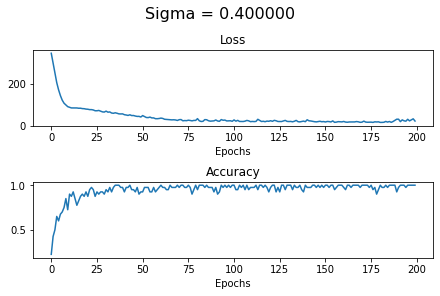

In [ ]:
#Pour différentes valeurs de l'écart-type du bruit
#list_noise_std = [0.1,0.2,0.3,0.4,0.5] # pour comparer plusieurs sigma
list_noise_std = [0.4]

# Initialisation de la liste qui contiendra les performances (accuracy) pour chaque écart-type
accuracy_list = list_noise_std.copy()

num_epochs =  200
    
for i in range(1):
    
    # Initialisation du modèle 
    model = get_ladder_network_fc(layer_sizes=[16384, 1000, 500, 500, 500, 250, 4], noise_std=list_noise_std[i])

    # Entrainement du modèle
    history = model.fit([X_train_labeled_rep, X_train_unlabeled], y_train_labeled_rep, epochs=num_epochs)

    #Affichage des courbes de perte et de performance
    xc = range(num_epochs)
    fig, axs = plt.subplots(2, 1, constrained_layout=True)
    axs[0].plot(xc,history.history['loss'])
    axs[0].set_title('Loss')
    axs[0].set_xlabel('Epochs')
    fig.suptitle('Sigma = %f'% list_noise_std[i] ,fontsize=16)
    axs[1].plot(xc,history.history['accuracy'])
    axs[1].set_xlabel('Epochs')
    axs[1].set_title('Accuracy')

In [ ]:
y_test_pr = model.test_model.predict(X_test, batch_size=10)
accuracy_list[i] = accuracy_score(y_test, y_test_pr.argmax(-1))
print(f"Test accuracy : {accuracy_list[i]}")

Test accuracy : 0.425


In [ ]:
model.save('/content/drive/MyDrive/ladder network.h5')